# Introduction
This notebook was written by Rafael Oliveira on 2024-07-08.

In this notebook, you will find examples of various fundamental data processing procedures including:

- **Data Preparation**: Demonstrates how to organize and preprocess interest rate futures data for analysis.
- **Interpolation Methods**: Shows how to use linear interpolation, cubic spline interpolation, and the Nelson-Siegel model to create a continuous interest rate curve.
- **Extrapolation Methods**: Illustrates techniques such as linear extrapolation and forward rate extrapolation to estimate interest rates beyond the available data.
- **Visualization**: Provides examples of how to visualize both the interpolated and extrapolated data to uncover insights and trends.

This notebook serves as a practical guide and a starting point for more complex financial data analysis projects.

In [131]:
# Import necessary libraries
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d, CubicSpline
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [132]:
# Read the data from a csv file
# This data was previously generated from raw data available online in the project "br-futures-rates-data"
df = pd.read_csv('rates_DI1.csv').sort_values('years')
df.head()

,years,rates
0,0.091270,10.428952
1,0.178571,10.481974
2,0.261905,10.540018
3,0.353175,10.611002
4,0.428571,10.710012


In [133]:
# Linear Interpolation
def linear_interpolation(df, term):
    f = interp1d(df['years'], df['rates'])
    return f(term)

In [134]:
# Cubic Spline Interpolation
def cubic_spline_interpolation(df, term):
    cs = CubicSpline(df['years'], df['rates'])
    return cs(term)

In [135]:
# Nelson-Siegel Model
def nelson_siegel(t, beta0, beta1, beta2, tau):
    return beta0 + beta1 * (1 - np.exp(-t / tau)) / (t / tau) + beta2 * (((1 - np.exp(-t / tau)) / (t / tau)) - np.exp(-t / tau))

def ns_optimization(df):
    def ns_loss(params):
        beta0, beta1, beta2, tau = params
        rates_pred = nelson_siegel(df['years'], beta0, beta1, beta2, tau)
        return np.sum((df['rates'] - rates_pred) ** 2)

    initial_guess = [0.03, -0.02, 0.02, 2]
    result = minimize(ns_loss, initial_guess, method='L-BFGS-B')
    return result.x

In [136]:
# Polynomial Fitting
def polynomial_fitting(df, term, degree=3):
    coeffs = np.polyfit(df['years'], df['rates'], degree)
    poly = np.poly1d(coeffs)
    return poly(term)

In [137]:
# Linear Extrapolation
def linear_extrapolation(df, term):
    slope = (df['rates'].iloc[-1] - df['rates'].iloc[-2]) / (df['years'].iloc[-1] - df['years'].iloc[-2])
    intercept = df['rates'].iloc[-1] - slope * df['years'].iloc[-1]
    return slope * term + intercept

In [138]:
# Forward Rate Calculation (no bootstrapping needed since the futures rates used are zero-coupon)
def forward_rate_extrapolation(df, term):
    last_term = df['years'].iloc[-1]
    last_rate = df['rates'].iloc[-1]
    last_factor = (1 + last_rate/100) ** last_term
    second_last_term = df['years'].iloc[-2]
    second_last_rate = df['rates'].iloc[-2]
    second_last_factor = (1 + second_last_rate/100) ** second_last_term
    last_interval = last_term - second_last_term
    last_fwd_rate = 100 * ((last_factor / second_last_factor) ** (1/last_interval) - 1)
    extrapolated_factor = last_factor * (1 + last_fwd_rate/100) ** (term - last_term) 
    extrapolated_rate = 100 * (extrapolated_factor ** (1/term) - 1)
    return extrapolated_rate
forward_rate_extrapolation(df, 20)

np.float64(12.33053126260919)

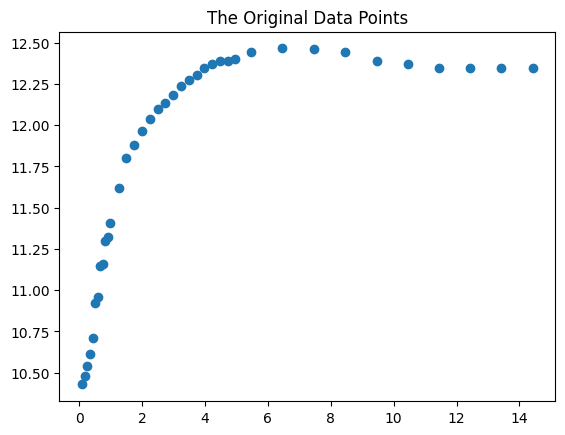

In [139]:
# Visualization
plt.scatter(df['years'], df['rates'])
plt.title('The Original Data Points')
plt.show()

In [140]:
longest_term = df['years'].max()
print(f"The longest term available in the dataset is {round(longest_term, 2)} year.")
print("Any estimation beyond it will be an extrapolation.")

The longest term available in the dataset is 14.42 year.
Any estimation beyond it will be an extrapolation.


In [141]:
# Defining terms for estimations
terms = np.linspace(min(df['years']), max(df['years']), 100)
extrapolated_terms = np.linspace(max(df['years']), max(df['years']) + 10, 50)

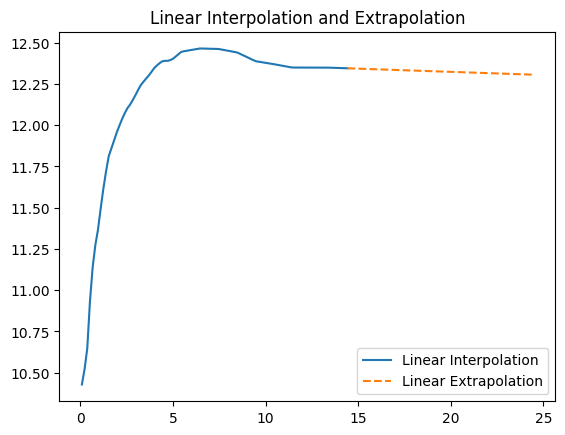

In [142]:
# Linear Interpolation and Extrapolation
plt.plot(terms, [linear_interpolation(df, t) for t in terms], label='Linear Interpolation')
plt.plot(extrapolated_terms, [linear_extrapolation(df, t) for t in extrapolated_terms], linestyle='--', label='Linear Extrapolation')
plt.title('Linear Interpolation and Extrapolation')
plt.legend()
plt.show()

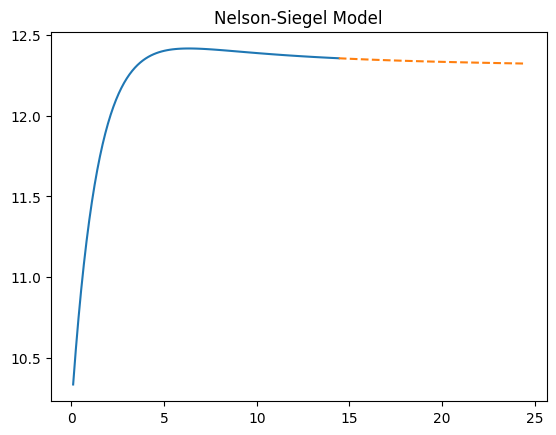

In [143]:
# Nelson-Siegel
params = ns_optimization(df)
plt.plot(terms, [nelson_siegel(t, *params) for t in terms], label='Nelson-Siegel')
plt.plot(extrapolated_terms, [nelson_siegel(t, *params) for t in extrapolated_terms], linestyle='--', label='Nelson-Siegel Extrapolation')
plt.title('Nelson-Siegel Model')
plt.show()

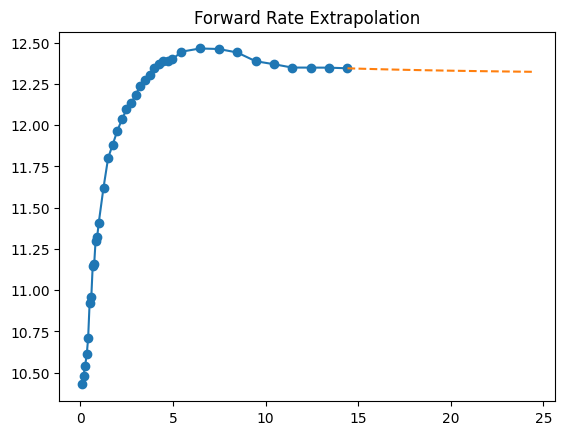

In [144]:
# Forward Rate Extrapolation
plt.plot(df['years'], df['rates'], label='Forward Rates', marker='o')
plt.plot(extrapolated_terms, [forward_rate_extrapolation(df, t) for t in extrapolated_terms], linestyle='--', label='Forward Rate Extrapolation')
plt.title('Forward Rate Extrapolation')
plt.show()

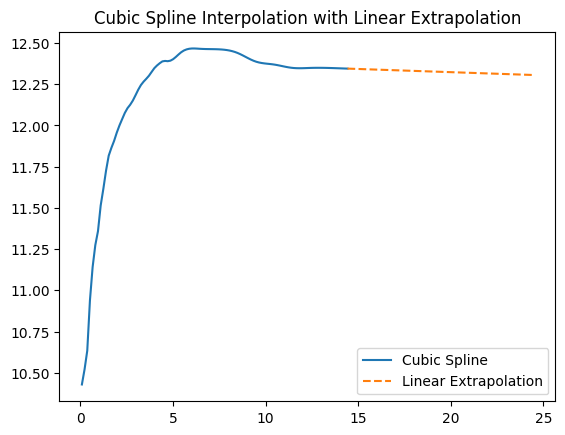

In [145]:
# Cubic Spline Interpolation with Linear Extrapolation
plt.plot(terms, [cubic_spline_interpolation(df, t) for t in terms], label='Cubic Spline')
plt.plot(extrapolated_terms, [linear_extrapolation(df, t) for t in extrapolated_terms], linestyle='--', label='Linear Extrapolation')
plt.title('Cubic Spline Interpolation with Linear Extrapolation')
plt.legend()
plt.show()

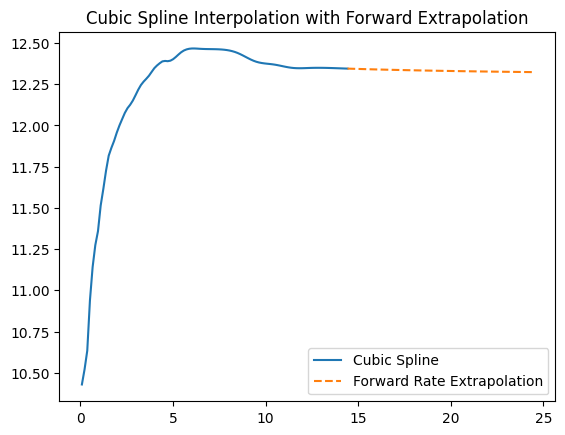

In [146]:
# Cubic Spline Interpolation with Forward Extrapolation
plt.plot(terms, [cubic_spline_interpolation(df, t) for t in terms], label='Cubic Spline')
plt.plot(extrapolated_terms, [forward_rate_extrapolation(df, t) for t in extrapolated_terms], linestyle='--', label='Forward Rate Extrapolation')
plt.title('Cubic Spline Interpolation with Forward Extrapolation')
plt.legend()
plt.show()

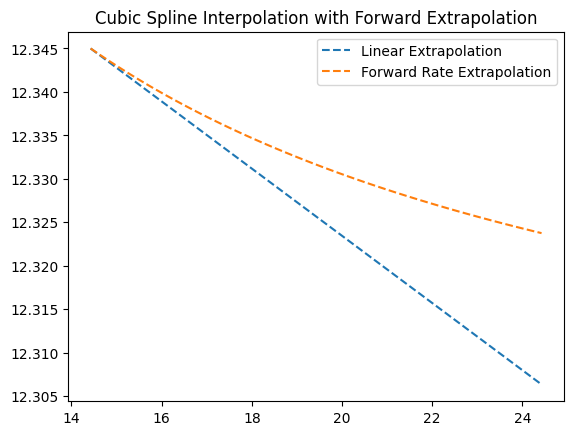

In [147]:
# Comparing extrapolation methods
plt.plot(extrapolated_terms, [linear_extrapolation(df, t) for t in extrapolated_terms], linestyle='--', label='Linear Extrapolation')
plt.plot(extrapolated_terms, [forward_rate_extrapolation(df, t) for t in extrapolated_terms], linestyle='--', label='Forward Rate Extrapolation')
plt.title('Cubic Spline Interpolation with Forward Extrapolation')
plt.legend()
plt.show()

The graph above illustrates two methods of extrapolation: linear extrapolation and forward rate extrapolation. 

Using forward rate extrapolation, the spot rates converge asymptotically to the last forward rate measured from the dataset. This behavior is more realistic as it reflects a stabilization in the rates over time, rather than a continuous decline. 

In contrast, linear extrapolation implies that spot rates will continue to decrease indefinitely. This implicitly suggests that forward rates are perpetually declining, which is not a plausible scenario in real-world financial markets. Forward rates typically stabilize or follow a more complex pattern rather than decreasing indefinitely.

Depending on the scenario and the magnitude of the extrapolation, the differences between these methods can be significant.

Therefore, forward rate extrapolation is preferred for its realistic representation of future rate behavior.